In [1]:
import numpy as np
from scipy.stats import truncnorm

In [48]:
class Layer(object):
  """層のクラス、親クラス"""
  def __init__(self, dim_input, dim_output, std=1., bias=0.):
    self.w = truncnorm(a=-2 * std, b=2 * std, scale=std).rvs((dim_input, dim_output)) #(dim_input, dim_output)
    self.b = np.ones(dim_output) * bias #(dim_out)

  def __call__(self, X):
    """順伝播"""
    self.input = X
    return self.forward_propagation(X)

  def back_propagation(self, delta, learning_rate):
    """逆伝搬
    :param delta: numpy.ndarray (num_data, dim_output)　誤差
    :param learning_rate: float 学習率
    :return delta: numpy.ndarray (num_data, dim_input)
    """
    delta = delta * self.activation_derivative() # (num_data, dim_output)
    w = np.copy(self.w)
    self.w -= learning_rate * np.dot(self.input.T, delta) #(dim_output, num_data)@(num_data, dim_input) = (dim_input, dim_output)
    self.b -= learning_rate * np.sum(delta, axis=0)

    return np.dot(delta, w.T) #(num_data, dim_out)@(dim_output, dim_input) = (num_data,dim_input)

class LinearLayer(Layer):
  def forward_propagation(self,X):
    """Linear-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    return X@self.w + self.b #(num_data, dim_output) + (dim_output) ★
  
  def activation_derivative(self):
    return 1

class SigmoidLayer(Layer):
  def forward_propagation(self,X):
    """Sigmoid-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    activ = X@self.w + self.b
    self.output = 1/(1 + np.exp(-activ))
    return self.output
  
  def activation_derivative(self):
    return self.output * (1 - self.output)

class SoftmaxLayer(Layer):
  def forward_propagation(self,X):
    """Softmax-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    activ = np.exp(X@self.w + self.b) #(num_data, output_dim)
    self.output = activ / np.sum(activ, axis=1)
    return self.output
  
  def activation_derivative(self):
    tmp = self.output.reshape((-1,1)) #(num_data, output_dim,1)
    return np.diag(self.output) - np.outer(tmp,tmp)

class TanhLayer(Layer):
  """Tanh-layer-class
  :param X: (num_data, input_dim)
  :return Ans: (num_data, output_dim)
  """
  def forward_propagation(self, X):
    activation = X.dot(self.w) + self.b
    self.output = np.tanh(activation)
    return self.output

  def activation_derivative(self):
    return 1 - self.output ** 2 

class ReLULayer(Layer):
  def forward_propagation(self,X):
    """ReLU-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    activation = X.dot(self.w) + self.b
    self.output = activation.clip(min=0)
    return self.output

  def activation_derivative(self):
    return (self.output > 0).astype(np.float)

class SigmoidCrossEntropy(object):
  def activate(self, logits):
    """Sigmoid-error-function
    :param logits: (num_data,dim_target) 
    :return Ans: (num_data, dim_target)
    """
    return 1/(1 + np.exp(-logits))

  def __call__(self, logits, targets):
    """Sigmoid-error-num
    :param logits: (num_data,dim_target=1) 
    :return Ans: float
    """
    probs = self.activate(logits)
    p = np.clip(probs, 1e-10, 1-1e-10)
    return np.sum(-targets * np.log(p) -(1-targets) * np.log(1-p))

  def delta(self, logits, targets):
    """Sigmoid-error-function-derivation
    :param logits: (num_data,dim_target=1) 
    :return Ans: (num_data, dim_target=1)
    """
    probs = self.activate(logits)
    return probs - targets

class SoftmaxCrossEntropy(object):
  def activate(self,logits):
    """Cross-entropy-function
    :param logits: (num_data, target_dim)
    :return Ans: (num_data, target_dim)
    """
    probs = logits / np.sum(logits, axis=1, keepdims=True) #(num_data, target_dim)/(num_data, 1) = (num_data, target_dim)
    return probs
  
  def __call__(self, logits, targets):
    """Cross-entropy-function
    :param logits: (num_data, target_dim)
    :return Ans: (num_data, target_dim)
    """
    probs = self.activate(logits) #(num_data, target_dim)
    return - np.sum(targets * np.log(probs)) #sum of (num_data, target_dim)@(target_dim, num_data)

  def delta(self, logits, targets):
    probs = self.activation(logits)
    return probs - targets

class SumSquaresError(object):

    def activate(self, X):
        return X

    def __call__(self, X, targets):
        return 0.5 * np.sum((X - targets) ** 2)

    def delta(self, X, targets):
        return X - targets

class NeuralNetwork(object):
  def __init__(self, layers, cost_function):
    """NeuralNetwork-Class
    :param layers: list of Layer's objects
    :param cost_functino: object of cost_function
    """
    self.layers = layers
    self.cost_function = cost_function

  def __call__(self,X):
    """順伝播"""
    for layer in self.layers:
      X = layer(X)

    return self.cost_function.activate(X)

  def fit(self, X, t, learning_rate):
    for layer in self.layers:
      X = layer(X)

    delta = self.cost_function.delta(X,t)
    for layer in reversed(self.layers):
      delta = layer.back_propagation(delta, learning_rate)

  def cost(self, X, t):
    for layer in self.layers:
      X = layer(X)
    return self.cost_function(X, t)

step 0, cost 732.2476220702788
step 10000, cost 35.33993597315573
step 20000, cost 29.283309395200014
step 30000, cost 26.73751550241787
step 40000, cost 25.661475802690287
step 50000, cost 24.577822544620005
step 60000, cost 25.34339965451712
step 70000, cost 23.282017121666282
step 80000, cost 23.352605371485332
step 90000, cost 23.22525812956216


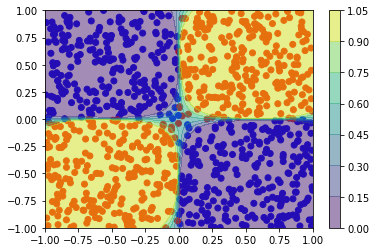

In [49]:
import matplotlib.pyplot as plt
def create_toy_datasets():
  x = np.random.uniform(-1, 1, size=(1000,2))
  labels = (np.prod(x, axis=1) > 0).astype(np.float)
  return x, labels.reshape((-1,1))

x, labels = create_toy_datasets()
colors = ["blue", "red"]
plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])

layers = [ TanhLayer(2,4), LinearLayer(4,1)]
cost_function = SigmoidCrossEntropy()
nn = NeuralNetwork(layers, cost_function)

for i in range(100000):
  if i % 10000 == 0:
    print(f"step {i}, cost {nn.cost(x, labels)}")
  nn.fit(x, labels, learning_rate=0.001)

X_test, Y_test = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
x_test = np.array([X_test, Y_test]).transpose(1,2,0).reshape(-1,2)
probs = nn(x_test)
probs = probs.reshape(100,100)
plt.contourf(X_test,Y_test,probs, alpha=0.5)
plt.colorbar()
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

step:0, cost:6.634417872638984
step:10000, cost:0.9015484793191566
step:20000, cost:0.24750834704150768
step:30000, cost:0.17601227890412638
step:40000, cost:0.16137672584379437
step:50000, cost:0.15652173009545778
step:60000, cost:0.15459384188357966
step:70000, cost:0.15360034841267955
step:80000, cost:0.15297295315591738
step:90000, cost:0.15253375661379426


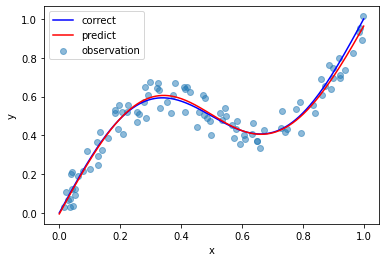

In [51]:
def func(x):
  return x + 0.3 * np.sin(2 * np.pi * x)

def create_toy_datasets(func, n=100):
  x = np.random.uniform(size=(n,1))
  t = func(x) + np.random.uniform(-0.1, 0.1, size=(n,1))
  return x,t

x, t = create_toy_datasets(func)

layers = [TanhLayer(1,6, std=1., bias=0.5), LinearLayer(6,1,std=1, bias=0.5)]
cost_function = SumSquaresError()
nn = NeuralNetwork(layers,cost_function)
for i in range(100000):
  if i % 10000 == 0:
    print(f"step:{i}, cost:{nn.cost(x,t)}")
  nn.fit(x,t,learning_rate=0.001)

plt.scatter(x, t, alpha=0.5, label="observation")
x_test = np.linspace(0,1,1000)[:,np.newaxis]
y = nn(x_test)
plt.plot(x_test, func(x_test), color="b", label="correct")
plt.plot(x_test, y, color="r", label="predict")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

多峰性と限界

step:0, cost:96.12794889351552
step:10000, cost:2.599459270647754
step:20000, cost:2.5914708429358138
step:30000, cost:2.5829751927491684
step:40000, cost:2.5704602083645227
step:50000, cost:2.549940132632939
step:60000, cost:2.517705830614128
step:70000, cost:2.4800906708535724
step:80000, cost:2.44967404545603
step:90000, cost:2.423359153911355


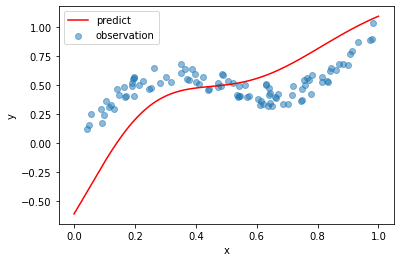

In [54]:
def func(x):
  return x + 0.3 * np.sin(2 * np.pi * x)

def create_toy_datasets(func, n=100):
  x = np.random.uniform(size=(n,1))
  t = func(x) + np.random.uniform(-0.1, 0.1, size=(n,1))
  return x,t

t, x = create_toy_datasets(func)


layers = [TanhLayer(1,6, std=1., bias=0.5), LinearLayer(6,1,std=1, bias=0.5)]
cost_function = SumSquaresError()
nn = NeuralNetwork(layers,cost_function)
for i in range(100000):
  if i % 10000 == 0:
    print(f"step:{i}, cost:{nn.cost(x,t)}")
  nn.fit(x,t,learning_rate=0.001)

plt.scatter(t, x, alpha=0.5, label="observation")
x_test = np.linspace(0,1,1000)[:,np.newaxis]
y = nn(x_test)
#plt.plot(x_test, func(x_test), color="b", label="correct")
plt.plot(x_test, y, color="r", label="predict")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()